# OpenAQ AQI Prediction — Full Colab Notebook

End-to-end pipeline:
- Load `openaq.csv` from Google Drive
- Use `preprocessing.py` from the cloned GitHub repo to clean/standardize
- Pivot long → wide (pollutants as columns)
- Compute AQI (US EPA breakpoints) from standardized pollutant concentrations
- Build time + lag features
- Train baseline + RandomForest with time-series CV

**Expected Drive path:** `/content/drive/MyDrive/data_set/openaq.csv`  
**Outputs saved to:** `/content/drive/MyDrive/data/`

In [11]:
# =============================
# 0) Setup: Drive + Repo
# =============================
from google.colab import drive
drive.mount('/content/drive')

# Clone repo (safe if already cloned)
!test -d /content/openaq-aqi-predictor || git clone https://github.com/AshVenn/openaq-aqi-predictor.git

from pathlib import Path
import sys

REPO_ROOT = Path("/content/openaq-aqi-predictor").resolve()
SRC_DIR = REPO_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

# Paths
DATA_PATH = Path("/content/drive/MyDrive/data_set/openaq.csv").resolve()
OUTPUT_DIR = Path("/content/drive/MyDrive/data").resolve()
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Repo:", REPO_ROOT.exists(), "| src:", SRC_DIR.exists())
print("Dataset:", DATA_PATH.exists())
print("Output dir:", OUTPUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Repo: True | src: True
Dataset: True
Output dir: /content/drive/MyDrive/data


In [12]:
# =============================
# 1) Imports
# =============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)


In [13]:
# =============================
# 2) Load + clean (from repo preprocessing.py)
# =============================
import importlib
import preprocessing
importlib.reload(preprocessing)

from preprocessing import load_raw_data, clean_raw_data

raw_df = load_raw_data(str(DATA_PATH))
clean_df = clean_raw_data(raw_df)

print("raw_df:", raw_df.shape)
print("clean_df:", clean_df.shape)
display(clean_df.head())
print("Columns:", list(clean_df.columns))

# Save long cleaned data
processed_long_path = OUTPUT_DIR / "processed_long.csv"
clean_df.to_csv(processed_long_path, index=False)
print("Saved:", processed_long_path)


raw_df: (61177, 10)
clean_df: (43787, 9)


,city,location,latitude,longitude,timestamp,pollutant,value_std,unit_std,source_name
0,NaN,市八十六中,23.1047,113.4332,2021-08-09 11:00:00,o3,0.018337,ppm,ChinaAQIData
1,NaN,市农科院,21.9508,108.6553,2020-12-31 16:00:00,so2,2.671297,ppb,ChinaAQIData
3,NaN,市委,30.4576,106.6303,2021-08-09 11:00:00,o3,0.046353,ppm,ChinaAQIData
4,NaN,市委党校,27.7314,112.0194,2021-08-09 11:00:00,no2,10.096718,ppb,ChinaAQIData
5,NaN,市审计局,25.8071,113.0383,2021-08-09 11:00:00,o3,0.057559,ppm,ChinaAQIData


Columns: ['city', 'location', 'latitude', 'longitude', 'timestamp', 'pollutant', 'value_std', 'unit_std', 'source_name']
Saved: /content/drive/MyDrive/data/processed_long.csv


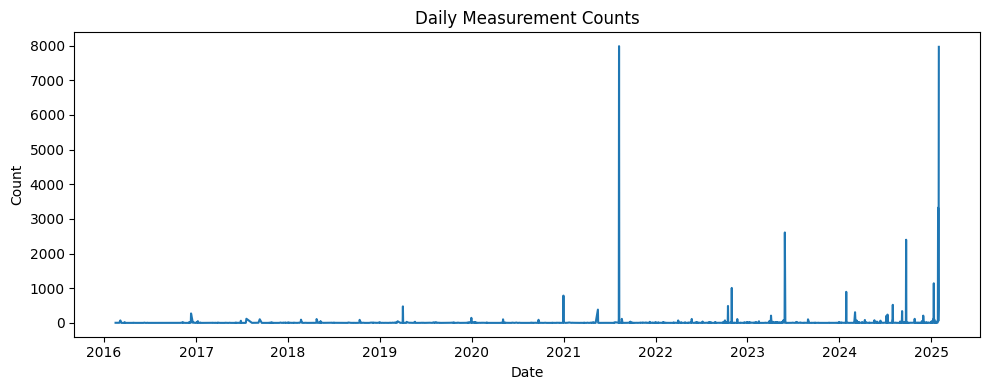

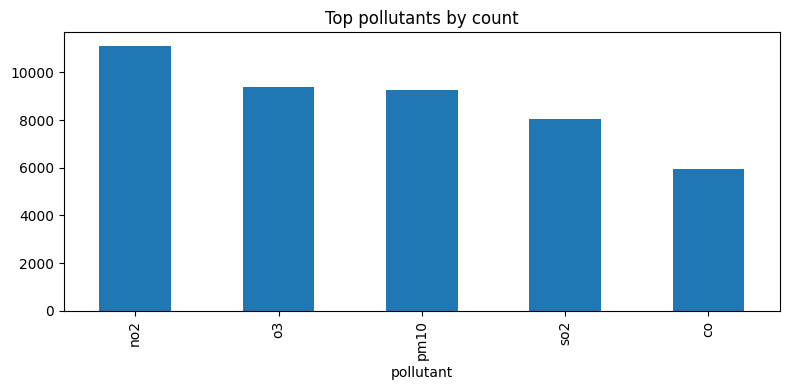

In [14]:
# =============================
# 3) Quick sanity plots (long format)
# =============================
clean_df["timestamp"] = pd.to_datetime(clean_df["timestamp"], errors="coerce")

counts = clean_df.groupby(clean_df["timestamp"].dt.date).size()
plt.figure(figsize=(10,4))
counts.plot()
plt.title("Daily Measurement Counts")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Pollutant distribution (counts)
plt.figure(figsize=(8,4))
clean_df["pollutant"].value_counts().head(15).plot(kind="bar")
plt.title("Top pollutants by count")
plt.tight_layout()
plt.show()


## AQI computation
We compute AQI from pollutant concentrations using **US EPA** breakpoints.

- Compute **sub-index (IAQI)** for each pollutant using linear interpolation
- Final **AQI = max(IAQI)** across pollutants

This notebook assumes `value_std` is already standardized by your `clean_raw_data()` step.
If a pollutant is missing at a timestamp/location, it’s ignored for the max.

In [15]:
# =============================
# 4) Pivot long -> wide (ML-ready table)
# Your clean_df columns: ['city','location','latitude','longitude','timestamp','pollutant','value_std','unit_std','source_name']
# =============================
df = clean_df.copy()
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["pollutant"] = df["pollutant"].astype(str).str.lower()

wanted_pollutants = ["pm25", "pm10", "no2", "o3", "co", "so2"]
df = df[df["pollutant"].isin(wanted_pollutants)].copy()

features_df = (
    df.pivot_table(
        index=["city", "location", "latitude", "longitude", "timestamp"],
        columns="pollutant",
        values="value_std",          # IMPORTANT: standardized numeric value
        aggfunc="mean"
    )
    .reset_index()
)
features_df.columns.name = None

print("features_df:", features_df.shape)
display(features_df.head())


features_df: (11578, 10)


,city,location,latitude,longitude,timestamp,co,no2,o3,pm10,so2
0,- LOC. CASA STABBI - Chitignano (AR),AR-CASA-STABBI,43.660280,11.901670,2025-01-10 01:00:00,NaN,NaN,NaN,10.0000,NaN
1,- LOC. CASA STABBI - Chitignano (AR),AR-CASA-STABBI,43.660280,11.901670,2025-01-11 21:00:00,NaN,1.062812,0.038203,NaN,NaN
2,-9999 - Acquapendente (VT),ACQUAPENDENTE,42.736572,11.876430,2025-01-11 21:00:00,NaN,2.125625,0.031581,NaN,NaN
3,"1010 Wien, Stephansplatz 1",Stephansplatz,48.208150,16.373254,2025-01-31 08:00:00,NaN,10.509363,0.022116,NaN,0.400165
4,1020 Wien,A23 Südosttangente/Wehlistraße,48.203060,16.434550,2025-01-31 08:00:00,0.207514,16.840507,NaN,13.0235,NaN


In [16]:
# =============================
# 5) AQI breakpoints (US EPA) + helpers
# Units (typical US EPA AQI):
# - PM2.5: µg/m³ (24h) [we treat your value_std as matching]
# - PM10 : µg/m³ (24h)
# - O3   : ppb (8h) or ppm; here use ppb-style breakpoints for simplicity
# - NO2  : ppb (1h)
# - SO2  : ppb (1h)
# - CO   : ppm (8h)
#
# NOTE: If your 'value_std' is in different units, you must convert accordingly.
# We'll include simple conversions for CO if it seems too large/small (optional).
# =============================
from typing import Dict, List, Tuple, Optional

AQI_BANDS = [
    (0, 50),
    (51, 100),
    (101, 150),
    (151, 200),
    (201, 300),
    (301, 400),
    (401, 500),
]

# Breakpoints: pollutant -> list of (BPlo, BPhi, Ilo, Ihi)
# These are commonly used US EPA breakpoint ranges.
BREAKPOINTS: Dict[str, List[Tuple[float, float, int, int]]] = {
    "pm25": [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ],
    "pm10": [
        (0, 54, 0, 50),
        (55, 154, 51, 100),
        (155, 254, 101, 150),
        (255, 354, 151, 200),
        (355, 424, 201, 300),
        (425, 504, 301, 400),
        (505, 604, 401, 500),
    ],
    # O3 8-hour (ppm) breakpoints often used; here we store in ppb for convenience:
    # 0.054 ppm = 54 ppb, etc.
    "o3": [
        (0, 54, 0, 50),
        (55, 70, 51, 100),
        (71, 85, 101, 150),
        (86, 105, 151, 200),
        (106, 200, 201, 300),
    ],
    "no2": [
        (0, 53, 0, 50),
        (54, 100, 51, 100),
        (101, 360, 101, 150),
        (361, 649, 151, 200),
        (650, 1249, 201, 300),
        (1250, 1649, 301, 400),
        (1650, 2049, 401, 500),
    ],
    "so2": [
        (0, 35, 0, 50),
        (36, 75, 51, 100),
        (76, 185, 101, 150),
        (186, 304, 151, 200),
        (305, 604, 201, 300),
        (605, 804, 301, 400),
        (805, 1004, 401, 500),
    ],
    # CO in ppm (8h)
    "co": [
        (0.0, 4.4, 0, 50),
        (4.5, 9.4, 51, 100),
        (9.5, 12.4, 101, 150),
        (12.5, 15.4, 151, 200),
        (15.5, 30.4, 201, 300),
        (30.5, 40.4, 301, 400),
        (40.5, 50.4, 401, 500),
    ],
}

def iaqi_from_breakpoints(c: float, bps: List[Tuple[float, float, int, int]]) -> Optional[float]:
    if c is None or (isinstance(c, float) and np.isnan(c)):
        return None
    for BPlo, BPhi, Ilo, Ihi in bps:
        if BPlo <= c <= BPhi:
            # IAQI = (Ihi − Ilo)/(BPhi − BPlo) × (C − BPlo) + Ilo
            return (Ihi - Ilo) / (BPhi - BPlo) * (c - BPlo) + Ilo
    # Out of range: cap to 500 if above highest
    if c > bps[-1][1]:
        return 500.0
    return None

def compute_aqi_row(row: pd.Series, pollutants: List[str]) -> float:
    iaqis = []
    for p in pollutants:
        if p not in BREAKPOINTS or p not in row.index:
            continue
        val = row[p]
        # Optional heuristic for O3: if values look like ppm (e.g., 0.07), convert to ppb
        if p == "o3" and pd.notna(val) and val < 1.0:
            val = val * 1000.0  # ppm -> ppb heuristic
        # Optional heuristic for NO2/SO2: if values look like ppm (<1), convert to ppb
        if p in ("no2","so2") and pd.notna(val) and val < 1.0:
            val = val * 1000.0
        iaqi = iaqi_from_breakpoints(float(val), BREAKPOINTS[p])
        if iaqi is not None:
            iaqis.append(iaqi)
    return float(np.max(iaqis)) if iaqis else np.nan


In [17]:
# =============================
# 6) Compute AQI target
# =============================
pollutant_cols_present = [c for c in ["pm25","pm10","no2","o3","co","so2"] if c in features_df.columns]
print("Pollutant cols present:", pollutant_cols_present)

features_df["aqi"] = features_df.apply(lambda r: compute_aqi_row(r, pollutant_cols_present), axis=1)

print("AQI null rate:", features_df["aqi"].isna().mean())
display(features_df[["timestamp","location","aqi"] + pollutant_cols_present].head())


Pollutant cols present: ['pm10', 'no2', 'o3', 'co', 'so2']
AQI null rate: 0.020556227327690448


,timestamp,location,aqi,pm10,no2,o3,co,so2
0,2025-01-10 01:00:00,AR-CASA-STABBI,9.259259,10.0000,NaN,NaN,NaN,NaN
1,2025-01-11 21:00:00,AR-CASA-STABBI,35.373264,NaN,1.062812,0.038203,NaN,NaN
2,2025-01-11 21:00:00,ACQUAPENDENTE,29.241898,NaN,2.125625,0.031581,NaN,NaN
3,2025-01-31 08:00:00,Stephansplatz,232.509439,NaN,10.509363,0.022116,NaN,0.400165
4,2025-01-31 08:00:00,A23 Südosttangente/Wehlistraße,15.887271,13.0235,16.840507,NaN,0.207514,NaN


In [18]:
# =============================
# 7) Add time + lag features (from repo features.py)
# =============================
from features import add_time_features, add_lag_features, build_feature_columns

features_df = add_time_features(features_df, time_col="timestamp")

features_df = add_lag_features(
    features_df,
    group_cols=["location"],
    target_cols=pollutant_cols_present,
    lags=(1,),
    time_col="timestamp"
)

feature_cols = build_feature_columns(pollutant_cols_present, include_lags=True)

print("Num feature cols:", len(feature_cols))
print(feature_cols[:10], "...")

# Save engineered dataset
processed_features_path = OUTPUT_DIR / "processed_features.csv"
features_df.to_csv(processed_features_path, index=False)
print("Saved:", processed_features_path)


Num feature cols: 15
['pm10', 'no2', 'o3', 'co', 'so2', 'hour', 'day_of_week', 'month', 'latitude', 'longitude'] ...
Saved: /content/drive/MyDrive/data/processed_features.csv


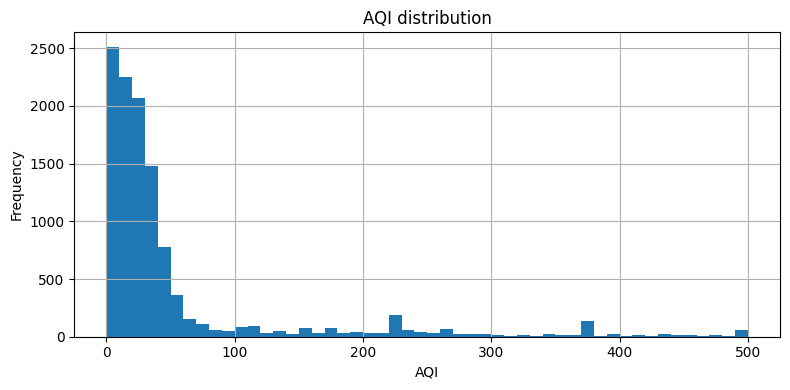

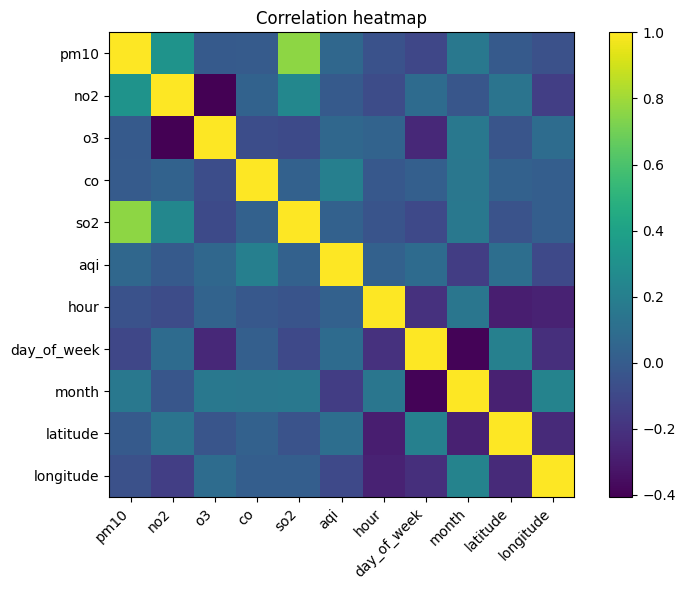

In [19]:
# =============================
# 8) Quick EDA: AQI distribution + correlation
# =============================
plt.figure(figsize=(8,4))
features_df["aqi"].dropna().hist(bins=50)
plt.title("AQI distribution")
plt.xlabel("AQI")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Correlation heatmap (numeric only)
num_df = features_df[[c for c in (pollutant_cols_present + ["aqi","hour","day_of_week","month","latitude","longitude"]) if c in features_df.columns]].dropna()
corr = num_df.corr(numeric_only=True)

plt.figure(figsize=(8,6))
plt.imshow(corr.values)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Correlation heatmap")
plt.tight_layout()
plt.show()


In [22]:
!pip -q install xgboost
!pip -q install lightgbm
!pip -q install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 4.5 MB/s eta 0:00:00


In [23]:
# =============================
# 9) Modeling (baseline + Boosting models)
# - Gradient Boosting (sklearn)
# - XGBoost
# - CatBoost
# - LightGBM
# =============================

import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import HistGradientBoostingRegressor

# -------------------------
# Helpers
# -------------------------
def train_test_split_time(df, time_col="timestamp", test_size=0.2):
    df = df.sort_values(time_col)
    split_index = int(len(df) * (1 - test_size))
    return df.iloc[:split_index].copy(), df.iloc[split_index:].copy()

def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)  # no squared kwarg
    rmse = float(np.sqrt(mse))
    return {
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "rmse": rmse,
        "r2": float(r2_score(y_true, y_pred)),
    }

def summarize_metrics(m):
    return f"MAE={m['mae']:.2f}, RMSE={m['rmse']:.2f}, R2={m['r2']:.3f}"

# -------------------------
# Data
# -------------------------
df_model = features_df.dropna(subset=["aqi"]).copy()
feature_cols_final = [c for c in feature_cols if c in df_model.columns]

train_df, test_df = train_test_split_time(df_model, time_col="timestamp", test_size=0.2)

X_train = train_df[feature_cols_final].values
X_test  = test_df[feature_cols_final].values

# ✅ AQI is spiky: log target usually works MUCH better
USE_LOG_TARGET = True

if USE_LOG_TARGET:
    y_train = np.log1p(train_df["aqi"].values)
    y_test  = np.log1p(test_df["aqi"].values)
else:
    y_train = train_df["aqi"].values
    y_test  = test_df["aqi"].values

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Num features:", len(feature_cols_final))
print("Log target:", USE_LOG_TARGET)

# For time series CV
tscv = TimeSeriesSplit(n_splits=3)

# Utility: convert predictions back to AQI scale if log target
def invert_pred(y_pred):
    return np.expm1(y_pred) if USE_LOG_TARGET else y_pred

# -------------------------
# 1) Baseline: Linear Regression
# -------------------------
baseline_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LinearRegression())
])
baseline_model.fit(X_train, y_train)
baseline_pred = invert_pred(baseline_model.predict(X_test))

baseline_m = regression_metrics(test_df["aqi"].values, baseline_pred)  # evaluate on real AQI scale
print("Baseline:", summarize_metrics(baseline_m))

results = []
results.append(("LinearRegression", baseline_m, None))

# -------------------------
# 2) Sklearn Gradient Boosting (HistGBDT) — strong & fast
# -------------------------
hgb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(random_state=SEED))
])

hgb_grid = {
    "model__max_depth": [3, 6, None],
    "model__learning_rate": [0.05, 0.1],
    "model__max_iter": [300, 600],
}

hgb_search = GridSearchCV(
    hgb_pipe,
    param_grid=hgb_grid,
    cv=tscv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)
hgb_search.fit(X_train, y_train)
hgb_best = hgb_search.best_estimator_

hgb_pred = invert_pred(hgb_best.predict(X_test))
hgb_m = regression_metrics(test_df["aqi"].values, hgb_pred)

print("HistGBDT:", summarize_metrics(hgb_m))
print("  Best params:", hgb_search.best_params_)
results.append(("HistGradientBoosting", hgb_m, hgb_search.best_params_))

# -------------------------
# 3) XGBoost (optional)
# -------------------------
try:
    from xgboost import XGBRegressor

    xgb_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", XGBRegressor(
            random_state=SEED,
            n_estimators=800,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            n_jobs=-1,
            objective="reg:squarederror",
        ))
    ])

    # Light grid (avoid huge runtime)
    xgb_grid = {
        "model__max_depth": [4, 6, 8],
        "model__subsample": [0.8, 0.9, 1.0],
        "model__colsample_bytree": [0.8, 0.9, 1.0],
    }

    xgb_search = GridSearchCV(
        xgb_pipe,
        param_grid=xgb_grid,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    xgb_search.fit(X_train, y_train)
    xgb_best = xgb_search.best_estimator_

    xgb_pred = invert_pred(xgb_best.predict(X_test))
    xgb_m = regression_metrics(test_df["aqi"].values, xgb_pred)

    print("XGBoost:", summarize_metrics(xgb_m))
    print("  Best params:", xgb_search.best_params_)
    results.append(("XGBoost", xgb_m, xgb_search.best_params_))

except Exception as e:
    print("XGBoost skipped (not installed or error):", repr(e))

# -------------------------
# 4) CatBoost (optional) — great with noisy data
# -------------------------
try:
    from catboost import CatBoostRegressor

    # CatBoost can handle NaNs, but we keep SimpleImputer for consistency
    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", CatBoostRegressor(
            random_seed=SEED,
            loss_function="MAE",
            verbose=False,
            iterations=2000,
            learning_rate=0.05,
            depth=8,
        ))
    ])

    cat_grid = {
        "model__depth": [6, 8, 10],
        "model__learning_rate": [0.03, 0.05, 0.1],
    }

    cat_search = GridSearchCV(
        cat_pipe,
        param_grid=cat_grid,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    cat_search.fit(X_train, y_train)
    cat_best = cat_search.best_estimator_

    cat_pred = invert_pred(cat_best.predict(X_test))
    cat_m = regression_metrics(test_df["aqi"].values, cat_pred)

    print("CatBoost:", summarize_metrics(cat_m))
    print("  Best params:", cat_search.best_params_)
    results.append(("CatBoost", cat_m, cat_search.best_params_))

except Exception as e:
    print("CatBoost skipped (not installed or error):", repr(e))

# -------------------------
# 5) LightGBM (optional)
# -------------------------
try:
    from lightgbm import LGBMRegressor

    lgb_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", LGBMRegressor(
            random_state=SEED,
            n_estimators=2000,
            learning_rate=0.03,
            num_leaves=31,
            subsample=0.9,
            colsample_bytree=0.9,
            n_jobs=-1,
        ))
    ])

    lgb_grid = {
        "model__num_leaves": [31, 63, 127],
        "model__max_depth": [-1, 6, 10],
    }

    lgb_search = GridSearchCV(
        lgb_pipe,
        param_grid=lgb_grid,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )
    lgb_search.fit(X_train, y_train)
    lgb_best = lgb_search.best_estimator_

    lgb_pred = invert_pred(lgb_best.predict(X_test))
    lgb_m = regression_metrics(test_df["aqi"].values, lgb_pred)

    print("LightGBM:", summarize_metrics(lgb_m))
    print("  Best params:", lgb_search.best_params_)
    results.append(("LightGBM", lgb_m, lgb_search.best_params_))

except Exception as e:
    print("LightGBM skipped (not installed or error):", repr(e))

# -------------------------
# Summary table
# -------------------------
summary = (
    pd.DataFrame([
        {"model": name, **metrics}
        for name, metrics, _params in results
    ])
    .sort_values("mae")
)

display(summary)


Train shape: (9072, 15) Test shape: (2268, 15)
Num features: 15
Log target: True
Baseline: MAE=46.27, RMSE=105.77, R2=-0.172
HistGBDT: MAE=7.68, RMSE=25.98, R2=0.929
  Best params: {'model__learning_rate': 0.05, 'model__max_depth': None, 'model__max_iter': 300}
XGBoost: MAE=6.06, RMSE=16.98, R2=0.970
  Best params: {'model__colsample_bytree': 0.9, 'model__max_depth': 8, 'model__subsample': 0.9}


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CatBoost: MAE=7.87, RMSE=28.75, R2=0.913
  Best params: {'model__depth': 8, 'model__learning_rate': 0.03}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3042
[LightGBM] [Info] Number of data points in the train set: 9072, number of used features: 15
[LightGBM] [Info] Start training from score 3.142974
LightGBM: MAE=5.58, RMSE=16.81, R2=0.970
  Best params: {'model__max_depth': -1, 'model__num_leaves': 63}


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,model,mae,rmse,r2
4,LightGBM,5.577790,16.812449,0.970401
2,XGBoost,6.055505,16.975335,0.969825
1,HistGradientBoosting,7.676633,25.982809,0.929306
3,CatBoost,7.866040,28.749993,0.913446
0,LinearRegression,46.266036,105.774819,-0.171596


In [26]:
# After you build `summary`
best_name = summary.iloc[0]["model"]
print("Best model:", best_name)

# Map model name -> predictions (all on real AQI scale already)
pred_map = {
    "LinearRegression": baseline_pred,
    "HistGradientBoosting": hgb_pred,
}

# Only add these if they were actually trained (no errors)
if "XGBoost" in summary["model"].values:
    pred_map["XGBoost"] = xgb_pred
if "CatBoost" in summary["model"].values:
    pred_map["CatBoost"] = cat_pred
if "LightGBM" in summary["model"].values:
    pred_map["LightGBM"] = lgb_pred

pred = pred_map[best_name]            # ✅ this defines pred again
y_true = test_df["aqi"].values        # ✅ real AQI target


Best model: LightGBM


Median abs error: 0.7508163173332676
90th pct abs error: 13.981250320732405
99th pct abs error: 74.75181595645596


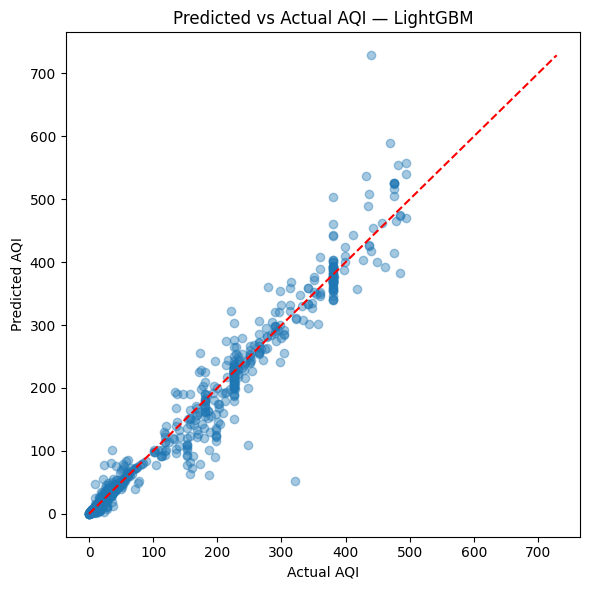

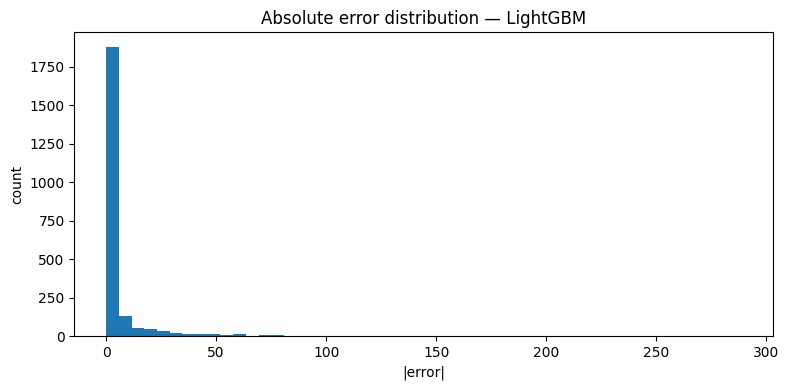

In [27]:
# =============================
# 10) Diagnostics (UPDATED)
# =============================
import numpy as np
import matplotlib.pyplot as plt

errors = np.abs(y_true - pred)
print("Median abs error:", float(np.median(errors)))
print("90th pct abs error:", float(np.percentile(errors, 90)))
print("99th pct abs error:", float(np.percentile(errors, 99)))

plt.figure(figsize=(6,6))
plt.scatter(y_true, pred, alpha=0.4)
mn = float(min(y_true.min(), pred.min()))
mx = float(max(y_true.max(), pred.max()))
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title(f"Predicted vs Actual AQI — {best_name}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.hist(errors, bins=50)
plt.title(f"Absolute error distribution — {best_name}")
plt.xlabel("|error|")
plt.ylabel("count")
plt.tight_layout()
plt.show()


## Notes / Next steps
- If AQI spikes dominate RMSE: try predicting `log1p(AQI)` and invert.
- Add rolling features (3h/6h) per location to improve temporal signal.
- Consider filtering rows with too many missing pollutant measurements.
